In [16]:
using MGVInference

In [2]:
fft_gp_model = "../test/test_models/fft_gp.jl"
open(fft_gp_model, "r") do io
    map(println, readlines(io))
end
include(fft_gp_model)

# This file is a part of MGVInference.jl, licensed under the MIT License (MIT).

import Base: *, adjoint
import AbstractFFTs
import FFTW: plan_r2r, DHT
import ForwardDiff
import Random: randn, MersenneTwister
import Distributions: Normal
import ValueShapes: NamedTupleDist
import Zygote
import LinearAlgebra: Diagonal

_dims = 40
_k = [i < _dims / 2 ? i : _dims-i for i = 0:_dims-1]

# Define the harmonic transform operator as a matrix-like object
_ht = plan_r2r(zeros(_dims), DHT)

# Unfortunately neither Zygote nor ForwardDiff support planned Hartley
# transformations. While Zygote does not support AbstractFFTs.ScaledPlan,
# ForwardDiff does not overload the appropriate methods from AbstractFFTs.
function _plan_dual_product(trafo::AbstractFFTs.Plan, u::Vector{ForwardDiff.Dual{T, V, N}}) where {T, V, N}
    # Unpack AoS -> SoA
    vs = ForwardDiff.value.(u)
    ps = mapreduce(ForwardDiff.partials, hcat, u)
    # Actual computation
    val = trafo * vs
    jvp = [trafo*t[:] for t in eachro

40-element Array{Float64,1}:
 -0.2182971373018973
 -1.7218447499307976
  0.603715678803879
 -0.21179751899630508
 -0.44777338300787084
 -0.4476889572053994
  2.013315941253755
  0.7635310957132931
 -0.0981351745482496
  0.14246898420247958
 -2.893510412007984
  0.271258492099812
  0.49524834448070404
  ⋮
  1.7356116899036684
  1.8546456957399085
  0.2265671769535978
  0.2545780573368525
 -0.1958819956230198
 -0.3239403481351395
  0.21917922464094056
 -0.3926885430284329
 -0.31484314959998216
  2.2659326905628294
 -0.289867554971233
  1.0991094524324592

In [3]:
using Distributions
using Random
using ValueShapes
using LinearAlgebra
using Plots

In [4]:
data = rand(model(true_params), 1)[1];

In [5]:
_common_grid = [1:_dims...];

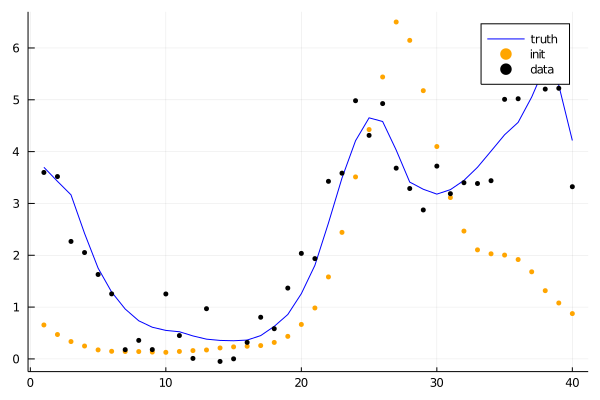

In [6]:
init_plots =() -> let
    truth = _mean(true_params)
    plot!(_common_grid, truth, markercolor=:blue, linecolor=:blue, label="truth")
    scatter!(_common_grid, _mean(starting_point), markercolor=:orange, markerstrokewidth=0, markersize=3, label="init")
    scatter!(_common_grid, MGVInference.unshaped(data), markercolor=:black, markerstrokewidth=0, markersize=3, label="data")
end
plot()
init_plots()

In [10]:
adjoint(FwdDerJacobianFunc(_mean)(true_params/2))*true_params/2

40-element Array{Float64,1}:
  0.3333463241697119
 -0.4657846123846112
  3.4150339461008983
 -0.1266968148658434
 -0.10047173480928366
  0.0012359188851375023
 -0.0016861855359320051
 -0.07141835791860478
 -0.025028684938751385
 -0.036855996585097715
  0.04127161493267094
 -0.006565582939142004
 -0.019007001762080283
  ⋮
  0.009080357976940527
 -0.00245627945976273
 -0.0027769421729672613
 -0.023003497421192308
  0.012078786892635262
  0.004702044218521904
  0.07270257652992543
 -0.03722623277391158
 -0.006573574357175052
  1.1559043639702413
  1.747144149891382
 -5.157221148048658

In [9]:
adjoint(FwdRevADJacobianFunc(_mean)(true_params/2))*true_params/2

40-element Array{Float64,1}:
  0.3333463241697121
 -0.46578461238461044
  3.415033946100897
 -0.12669681486584344
 -0.10047173480928365
  0.0012359188851375261
 -0.001686185535932036
 -0.07141835791860476
 -0.025028684938751374
 -0.036855996585097715
  0.04127161493267092
 -0.006565582939142
 -0.019007001762080283
  ⋮
  0.009080357976940531
 -0.002456279459762728
 -0.002776942172967265
 -0.023003497421192308
  0.01207878689263526
  0.004702044218521888
  0.0727025765299254
 -0.03722623277391163
 -0.0065735743571750695
  1.1559043639702415
  1.7471441498913818
 -5.157221148048657

In [11]:
first_iteration = mgvi_kl_optimize_step(model, data, starting_point; jacobian_func=FwdRevADJacobianFunc, residual_sampler=FullResidualSampler)

display(hcat(first_iteration, true_params))

40×2 Array{Float64,2}:
  0.37154     0.48151
 -0.908728   -0.564916
  1.59117     1.63042
 -0.891927   -1.14073
  0.187159    0.867529
 -0.179949    0.0598623
 -0.50573    -1.64938
  0.452754   -0.552528
  0.0995259  -0.472529
 -0.185605   -0.468033
  0.0334598  -0.200177
  0.210477   -0.944585
  0.0275408   0.75603
  ⋮          
 -0.186527   -0.268811
 -0.201712    0.0891861
 -0.349211   -2.73701
 -0.0453474  -1.57267
  0.264689   -0.859427
 -0.404471   -0.795277
 -0.816027   -0.75824
 -0.181748   -0.572864
 -0.514633   -0.559156
  0.590639    0.841274
  1.00892     0.298653
  1.26794     1.25313

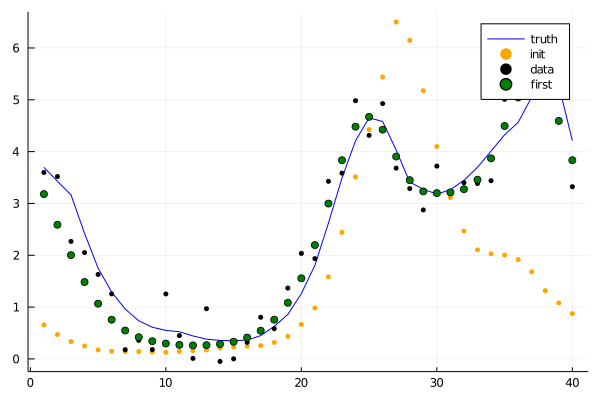

In [12]:
plot_iteration = (params, label) -> let
    #error_mat = mgvi_kl_errors(full_model, params)
    #display(error_mat)
    #errors = sqrt.(error_mat[diagind(error_mat)])
    #yerr = abs.(line(common_grid, params+errors) - line(common_grid, params-errors))
    #scatter!(common_grid, line(common_grid, params), markercolor=:green, label=label, yerr=yerr)
    scatter!(_common_grid, _mean(params), markercolor=:green, label=label)
end
    
plot()
init_plots()
plot_iteration(first_iteration, "first")

In [13]:
plot_iteration_light = (params, counter) -> let
    scatter!(_common_grid, _mean(params), markercolor=:green, markersize=3, markeralpha=2*atan(counter/18)/π, label=nothing)
end

#21 (generic function with 1 method)

40×2 Array{Float64,2}:
  0.37154     0.48151
 -0.908728   -0.564916
  1.59117     1.63042
 -0.891927   -1.14073
  0.187159    0.867529
 -0.179949    0.0598623
 -0.50573    -1.64938
  0.452754   -0.552528
  0.0995259  -0.472529
 -0.185605   -0.468033
  0.0334598  -0.200177
  0.210477   -0.944585
  0.0275408   0.75603
  ⋮          
 -0.186527   -0.268811
 -0.201712    0.0891861
 -0.349211   -2.73701
 -0.0453474  -1.57267
  0.264689   -0.859427
 -0.404471   -0.795277
 -0.816027   -0.75824
 -0.181748   -0.572864
 -0.514633   -0.559156
  0.590639    0.841274
  1.00892     0.298653
  1.26794     1.25313

40×2 Array{Float64,2}:
  0.455194    0.48151
 -0.766752   -0.564916
  1.64504     1.63042
 -0.898161   -1.14073
  0.0957131   0.867529
 -0.185946    0.0598623
 -0.547581   -1.64938
  0.498501   -0.552528
  0.15422    -0.472529
 -0.114515   -0.468033
  0.0685013  -0.200177
  0.23709    -0.944585
  0.0268521   0.75603
  ⋮          
 -0.190475   -0.268811
 -0.20786     0.0891861
 -0.348406   -2.73701
 -0.0526631  -1.57267
  0.242069   -0.859427
 -0.47876    -0.795277
 -0.909476   -0.75824
 -0.347045   -0.572864
 -0.580189   -0.559156
  0.36276     0.841274
  0.87475     0.298653
  1.19905     1.25313

40×2 Array{Float64,2}:
  0.4655      0.48151
 -0.749522   -0.564916
  1.60286     1.63042
 -0.916407   -1.14073
  0.12094     0.867529
 -0.137381    0.0598623
 -0.514058   -1.64938
  0.515636   -0.552528
  0.148486   -0.472529
 -0.104817   -0.468033
  0.0740519  -0.200177
  0.239503   -0.944585
  0.0267524   0.75603
  ⋮          
 -0.197241   -0.268811
 -0.210544    0.0891861
 -0.35419    -2.73701
 -0.0550049  -1.57267
  0.229143   -0.859427
 -0.467535   -0.795277
 -0.929895   -0.75824
 -0.348346   -0.572864
 -0.562847   -0.559156
  0.409584    0.841274
  0.85244     0.298653
  1.1803      1.25313

40×2 Array{Float64,2}:
  0.459673    0.48151
 -0.759286   -0.564916
  1.62799     1.63042
 -0.889855   -1.14073
  0.112868    0.867529
 -0.138761    0.0598623
 -0.556517   -1.64938
  0.524109   -0.552528
  0.145652   -0.472529
 -0.108025   -0.468033
  0.0765435  -0.200177
  0.234268   -0.944585
  0.0255697   0.75603
  ⋮          
 -0.193306   -0.268811
 -0.204491    0.0891861
 -0.346199   -2.73701
 -0.0643833  -1.57267
  0.238864   -0.859427
 -0.50076    -0.795277
 -0.919273   -0.75824
 -0.360799   -0.572864
 -0.568485   -0.559156
  0.374521    0.841274
  0.867661    0.298653
  1.19041     1.25313

40×2 Array{Float64,2}:
  0.449421    0.48151
 -0.773454   -0.564916
  1.6578      1.63042
 -0.86386    -1.14073
  0.101363    0.867529
 -0.144363    0.0598623
 -0.555226   -1.64938
  0.50718    -0.552528
  0.162362   -0.472529
 -0.117419   -0.468033
  0.0754462  -0.200177
  0.240247   -0.944585
  0.0308082   0.75603
  ⋮          
 -0.192597   -0.268811
 -0.203063    0.0891861
 -0.354481   -2.73701
 -0.0468446  -1.57267
  0.234272   -0.859427
 -0.493289   -0.795277
 -0.925792   -0.75824
 -0.308247   -0.572864
 -0.59711    -0.559156
  0.35303     0.841274
  0.897179    0.298653
  1.2087      1.25313

40×2 Array{Float64,2}:
  0.453323    0.48151
 -0.770524   -0.564916
  1.66409     1.63042
 -0.866667   -1.14073
  0.0660032   0.867529
 -0.159752    0.0598623
 -0.531028   -1.64938
  0.517975   -0.552528
  0.161632   -0.472529
 -0.0987825  -0.468033
  0.0759772  -0.200177
  0.23902    -0.944585
  0.0307381   0.75603
  ⋮          
 -0.194804   -0.268811
 -0.209743    0.0891861
 -0.349068   -2.73701
 -0.0567373  -1.57267
  0.227828   -0.859427
 -0.490547   -0.795277
 -0.919632   -0.75824
 -0.339128   -0.572864
 -0.597643   -0.559156
  0.324756    0.841274
  0.891439    0.298653
  1.20446     1.25313

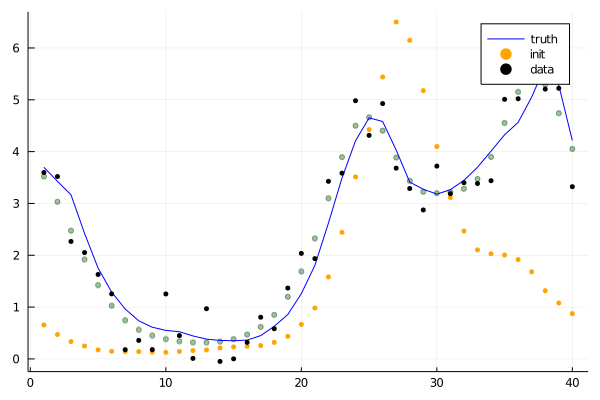

In [14]:
plt = scatter()
next_iteration = first_iteration
for i in 1:5
    display(hcat(next_iteration, true_params))
    next_iteration = mgvi_kl_optimize_step(model, data, next_iteration; jacobian_func=FwdDerJacobianFunc, residual_sampler=FullResidualSampler)
    plot_iteration_light(next_iteration, i)
end
display(hcat(next_iteration, true_params))

init_plots()
display(plt)

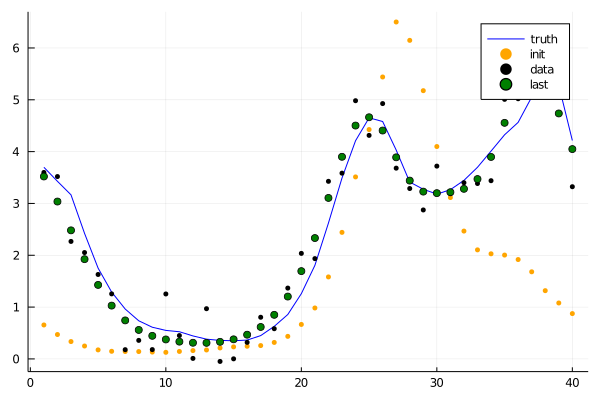

In [15]:
plot()
init_plots()
plot_iteration(next_iteration, "last")